# 2.  GP2 - Extracting LRRK2 G2019S carriers from the AJ population

### Description
**Project Title:** The age at onset of LRRK2 p.G2019S Parkinson's disease across ancestries and countries of origin

**Version:** Python 3.10, R 4.4.2    

**Last Updtated:** 20-MAR-2025

### Notebook Overview
- Load all files from the GP2 population where the G2019S variant information was available
- Get numbers of individuals with the AG or AA genotype
- Make a simple demographic overview
- Perform statistical analysis (AAO across populations - assessed with Cox proportional-hazards model) 

---
**Note:** This notebook is for the Ashkenazi Jewish (AJ) ancestry group, to apply to other ancestry groups simply assign the change "AJ" to the desired one from the following ancestries:

* African Admixed (AAC)
* African (AFR)
* Ashkenazi Jewish (AJ)
* American Admixed (AMR)
* Central Asian (CAS)
* East Asian (EAS)
* European (EUR)
* Middle Eastern (MDE)
* South Asian (SAS)

### Table of Contents:

1) [Getting started](#getting-started)
2) [Combine all files of all populations into one and get the number of G2019S AG/AA carriers per GP2 population](#combine-g2019s)
3) [Cox proportional-hazards model to assess age at onset of LRRK2 p.G2019S Parkinson's disease across ancestries and countries of origin](#cox-model)



## 1. Getting Started <a id="getting-started"></a>

### 1.1. Load the Python libraries

In [1]:
# Use the os package to interact with the environment
import os
import sys

# Bring in Pandas for Dataframe functionality
import pandas as pd
from functools import reduce

# Bring some visualization functionality 
import seaborn as sns

# numpy for basics
import numpy as np

# Use StringIO for working with file contents
from io import StringIO

# Enable IPython to display matplotlib graphs
import matplotlib.pyplot as plt
%matplotlib inline

# Enable interaction with the FireCloud API
from firecloud import api as fapi

# Import the iPython HTML rendering for displaying links to Google Cloud Console
#from IPython.core.display import display, HTML

# Import the iPython HTML rendering for displaying links to Google Cloud Console
from IPython.display import display, HTML

# Import urllib modules for building URLs to Google Cloud Console
import urllib.parse

# BigQuery for querying data
from google.cloud import bigquery

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### 1.2. Define Python functions to interact with GCP/Terra

In [2]:
# Utility routine for printing a shell command before executing it
def shell_do(command):
    print(f'Executing: {command}', file=sys.stderr)
    !$command
    
def shell_return(command):
    print(f'Executing: {command}', file=sys.stderr)
    output = !$command
    return '\n'.join(output)

# Utility routine for printing a query before executing it
def bq_query(query):
    print(f'Executing: {query}', file=sys.stderr)
    return pd.read_gbq(query, project_id=BILLING_PROJECT_ID, dialect='standard')

# Utility routine for display a message and a link
def display_html_link(description, link_text, url):
    html = f'''
    <p>
    </p>
    <p>
    {description}
    <a target=_blank href="{url}">{link_text}</a>.
    </p>
    '''

    display(HTML(html))

# Utility routines for reading files from Google Cloud Storage
def gcs_read_file(path):
    """Return the contents of a file in GCS"""
    contents = !gsutil -u {BILLING_PROJECT_ID} cat {path}
    return '\n'.join(contents)
    
def gcs_read_csv(path, sep=None):
    """Return a DataFrame from the contents of a delimited file in GCS"""
    return pd.read_csv(StringIO(gcs_read_file(path)), sep=sep, engine='python')

# Utility routine for displaying a message and link to Cloud Console
def link_to_cloud_console_gcs(description, link_text, gcs_path):
    url = '{}?{}'.format(
        os.path.join('https://console.cloud.google.com/storage/browser',
                     gcs_path.replace("gs://","")),
        urllib.parse.urlencode({'userProject': BILLING_PROJECT_ID}))

    display_html_link(description, link_text, url)

In [ ]:
%%bash

# Install Plink 1.9

# Create directory tools, check if exists
mkdir -p ~/tools
cd ~/tools

# Check if Plink 1.9 is already installed, install if not
if test -e /home/jupyter/tools/plink; then
    echo "Plink1.9 is already installed in /home/jupyter/tools/"

else
    echo -e "Downloading plink \n    -------"
    # Download plink1.9 from website
    wget -N http://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20190304.zip 
    unzip -o plink_linux_x86_64_20190304.zip
    
    echo -e "\n plink downloaded and unzipped in /home/jupyter/tools \n "
fi

Plink1.9 is already installed in /home/jupyter/tools/


In [ ]:
%%bash

# Install Plink 2.0
cd /home/jupyter/tools/

# Check if Plink 2.0 is already installed, install if not
if test -e /home/jupyter/tools/plink2; then
    echo "Plink2 is already installed in /home/jupyter/"

else
    echo "Plink2 is not installed"
    cd /home/jupyter/tools/
    # Download plink2.0 from website
    wget http://s3.amazonaws.com/plink2-assets/plink2_linux_x86_64_latest.zip
    unzip -o plink2_linux_x86_64_latest.zip

fi

Plink2 is already installed in /home/jupyter/


In [ ]:
%%bash

ls /home/jupyter/tools/

# Update permissions to make plink executable
chmod u+x /home/jupyter/tools/plink
chmod u+x /home/jupyter/tools/plink2

LICENSE
plink
plink2
plink2_linux_x86_64_latest.zip
plink_linux_x86_64_20190304.zip
prettify
toy.map
toy.ped
vcf_subset


In [ ]:
# Install rpy2 to run R in Python environment

! pip install rpy2


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [7]:
%load_ext rpy2.ipython

In [ ]:
%%R
# Print working directory
getwd()

[1] "/home/jupyter/LRRK2 pathogenic/edit"


In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/home/jupyter/packages’, ‘/usr/lib/R/site-library’ contain no packages


## 2. Combine all files of all populations into one and get the number of G2019S AG/AA carriers per GP2 population <a id="combine-g2019s"></a>

- Here only the AJ population is dispalyed as one example (N=600 LRRK2 G2019S variant carriers)
- As a next step all files across all populations will concatenated (N=895 LRRK2 G2019S variant carriers, in total)

In [ ]:
# Create a folder on your workspace
print("Making a working directory")
WORK_DIR = f'/home/jupyter/LRRK2_data_vis/'
shell_do(f'mkdir -p {WORK_DIR}') # f' stands for f-string which contains expressions inside brackets

Making a working directory


Executing: mkdir -p /home/jupyter/LRRK2_data_vis/


In [ ]:
%%R
# Change working directory
setwd('/home/jupyter/LRRK2_data_vis/')

# Import final output file from the previous notebook
data_AJ <- read.table("/home/jupyter/LRRK2_AJ/data_g2019s_merge_clin_AJ_r7.txt", strip.white = TRUE, na.string = "NA", header=TRUE)

# Import necessary libraries
library(dplyr)

# Update the data_AJ dataframe by adding a new column LRRK2_iPD_status
data_AJ <- data_AJ %>% 
  mutate(
    LRRK2_iPD_status = case_when(
      V7 == 'A' ~ "LRRK2-PD",
      V7 == 'G' ~ "iPD",
      V7 != 'G' & V7 != 'A'  ~ "NA", 
    )
  )

# Convert LRRK2_iPD_status column to a factor
data_AJ$LRRK2_iPD_status <- as.factor(data_AJ$LRRK2_iPD_status)

# Add a new column GP2_pop and assign the value "AJ" to all rows
data_AJ <- data_AJ %>% 
  mutate(
    GP2_pop = "AJ")

# Create a subset containing only rows where LRRK2_iPD_status is LRRK2-PD
LRRK2 <- subset(data_AJ, LRRK2_iPD_status == "LRRK2-PD")

# Get the number of rows
length(LRRK2$LRRK2_iPD_status)

# Repeat for all ancestries to get dataframes for each

[1] 600


In [ ]:
%%R
# Change working directory
setwd('/home/jupyter/LRRK2_data_vis/')

# Concatenate all dataframes for available ancestries
data <- rbind(data_AAC, data_AJ, data_AMR, 
              data_CAH, data_CAS, data_EUR,
              data_FIN, data_MDE)

# Subset the combined dataframe to only include rows where LRRK2_iPD_status is LRRK2-PD
LRRK2 <- subset(data, LRRK2_iPD_status == "LRRK2-PD")

# Return number of rows in LRRK2_iPD_status
length(LRRK2$LRRK2_iPD_status)

[1] 895


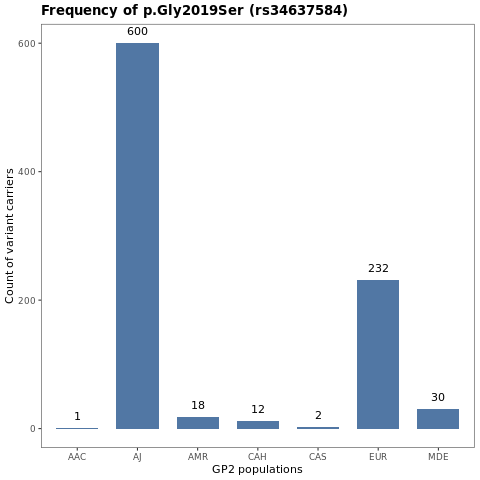

In [ ]:
%%R
# Change working directory
setwd('/home/jupyter/LRRK2_data_vis/')

# Import necessary libraries
library(magrittr)
library(ggplot2)
library(grid)
library(brew)
library(cowplot)
library(dbplyr)
library(dplyr)
library(png)
library(RColorBrewer)
library(tidyr)
library(tidyverse)

# Convert LRRK2_iPD_status and GP2_pop columns to factors
data$LRRK2_iPD_status <- as.factor(data$LRRK2_iPD_status)
data$GP2_pop <- as.factor(data$GP2_pop)

# Subset the fataframe to include only rows where LRRK2_iPD_status is LRRK2-PD
LRRK2 <- subset(data, LRRK2_iPD_status == "LRRK2-PD")
length(LRRK2$LRRK2_iPD_status)
summary(LRRK2)

# Create a plot for GP2_pop variable with LRRK2-PD subset
a <- ggplot(LRRK2, aes(x=factor(GP2_pop)))+
  geom_bar(stat="count", width=0.7, fill="#5177A4")+
  theme_bw() + theme(text=element_text(family="Calibri"), 
                     panel.grid.major = element_blank(), 
                     panel.grid.minor = element_blank(), 
                     plot.title = element_text(face = 'bold')) +
geom_text(stat='count', aes(label=after_stat(count)), vjust=-1) +
labs(x = "GP2 populations", y = "Count of variant carriers", 
       title = "Frequency of p.Gly2019Ser (rs34637584)")
# Show plot
a

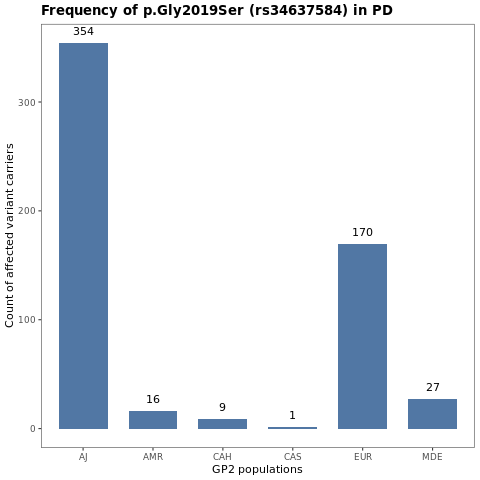

In [ ]:
%%R
# Change working directory
setwd('/home/jupyter/LRRK2_data_vis/')

# Convert LRRK2_iPD_status and GP2_pop columns to factors
data$LRRK2_iPD_status <- as.factor(data$LRRK2_iPD_status)
data$GP2_pop <- as.factor(data$GP2_pop)

# Subset the fataframe to include only rows where LRRK2_iPD_status is LRRK2-PD
LRRK2 <- subset(data, LRRK2_iPD_status == "LRRK2-PD")

# Update the LRRK2 dataframe by adding a new column Status_CPHM
LRRK2 <- LRRK2 %>% 
  mutate(Status_CPHM = case_when(
      baseline_GP2_phenotype_for_qc == 'PD' ~ 2,
      baseline_GP2_phenotype_for_qc == 'Control' ~ 1,
      baseline_GP2_phenotype_for_qc == 'Other' & baseline_GP2_phenotype == 'PD' ~ 2,
      baseline_GP2_phenotype_for_qc == 'Other' & baseline_GP2_phenotype == 'Control' ~ 1,
      baseline_GP2_phenotype_for_qc == 'Other' & baseline_GP2_phenotype == 'Population Control' ~ 1)
      )

# Subset the LRRK2 dataframe to include only rows where Status_CPHM is 2 (PD)
LRRK2_PD <- subset(LRRK2, Status_CPHM == 2)

# Create a plot for GP2_pop variable with LRRK2-PD subset
b <- ggplot(LRRK2_PD, aes(x=factor(GP2_pop)))+
  geom_bar(stat="count", width=0.7, fill="#5177A4")+
  theme_bw() + theme(text=element_text(family="Calibri"), 
                     panel.grid.major = element_blank(), 
                     panel.grid.minor = element_blank(), 
                     plot.title = element_text(face = 'bold')) +
# Add count labels on top of each bar
  geom_text(stat='count', aes(label=after_stat(count)), vjust=-1) +
# Add axis labels and plot title
  labs(x = "GP2 populations", 
       y = "Count of affected variant carriers", 
       title = "Frequency of p.Gly2019Ser (rs34637584) in PD")
# Show plot
b

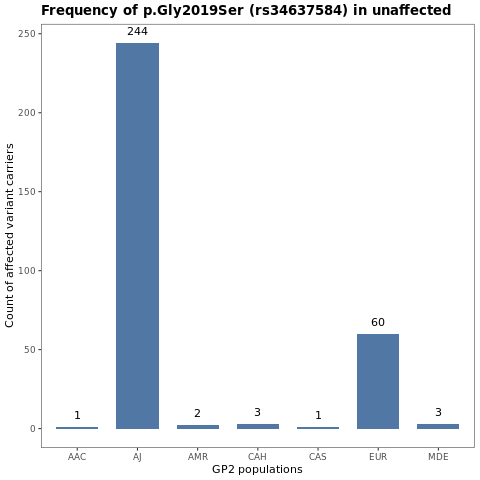

In [ ]:
%%R
# Subset the fataframe to include only rows where Status_CPHM is 1 (non-PD)
LRRK2_nonPD <- subset(LRRK2, Status_CPHM == 1)

# Return number of rows in LRRK2_iPD_status
length(LRRK2_nonPD$LRRK2_iPD_status)

# Create a plot for GP2_pop variable with LRRK2_nonPD subset
c <- ggplot(LRRK2_nonPD, aes(x=factor(GP2_pop)))+
  geom_bar(stat="count", width=0.7, fill="#5177A4")+
  theme_bw() + theme(text=element_text(family="Calibri"), 
                     panel.grid.major = element_blank(), 
                     panel.grid.minor = element_blank(), 
                   plot.title = element_text(face = 'bold')) +
# Add count labels on top of each bar
geom_text(stat='count', aes(label=after_stat(count)), vjust=-1) +
# Add axis labels and plot title
labs(x = "GP2 populations", 
     y = "Count of affected variant carriers", 
     title = "Frequency of p.Gly2019Ser (rs34637584) in unaffected")
# Show plot
c

## 3. Cox proportional-hazards model to assess age at onset of LRRK2 p.G2019S Parkinson's disease across ancestries and countries of origin  <a id="cox-model"></a>

Based on the analysis above, only include population with an N>10 variant carriers:
1) AJ
2) AMR
3) CAH
4) EUR
5) MDE


In [ ]:
%%R
# Change working directory
setwd('/home/jupyter/LRRK2_data_vis/')

# Subset concatenatied dataframe to include populations of interest
data_work <- subset(data, GP2_pop == "AJ" | GP2_pop == "AMR" | 
                    GP2_pop == "CAH"  | GP2_pop == "EUR" |
                   GP2_pop == "MDE" )

# Subset previous dataframe where LRRK2_iPD_status is "LRRK2-PD" or "iPD"
data_work <- subset(data_work, LRRK2_iPD_status == "LRRK2-PD" | LRRK2_iPD_status == "iPD")

#  Convert biological_sex_for_qc column to factor
data_work$biological_sex_for_qc <- as.factor(data_work$biological_sex_for_qc)
#  Convert related column to factor
data_work$related <- as.factor(data_work$related)

# Exclude related samples
data_work <- subset(data_work, related == 0)

In [ ]:
%%R
# Change working directory
setwd('/home/jupyter/LRRK2_data_vis/')

# Create new dataframe from data_work
data_work_CPHM <- data_work %>% 
# Update the dataframe by adding a new column Status_CPHM
mutate(Status_CPHM = case_when(
      baseline_GP2_phenotype_for_qc == 'PD' ~ 2,
      baseline_GP2_phenotype_for_qc == 'Control' ~ 1,
      baseline_GP2_phenotype_for_qc == 'Other' & baseline_GP2_phenotype == 'PD' ~ 2,
      baseline_GP2_phenotype_for_qc == 'Other' & baseline_GP2_phenotype == 'Control' ~ 1,
      baseline_GP2_phenotype_for_qc == 'Other' & baseline_GP2_phenotype == 'Population Control' ~ 1)
      )

# Create new dataframe, add column Age_CPHM based on Status_CPHM
data_work_CPHM <- data_work_CPHM %>% 
  mutate(
    Age_CPHM = case_when(
      Status_CPHM == 1 ~ age_at_sample_collection,
        Status_CPHM == 2 ~ coalesce(age_of_onset, age_at_diagnosis)
        )
      )

# Include only affected samples with GG geneotype and affected OR unaffected for AG/AA geneotype
data_work_CPHM <- subset(data_work_CPHM, LRRK2_iPD_status == "LRRK2-PD" | Status_CPHM == 2) 

In addition: Warning message:
In recalculate_width_panels(panel_positions, mapped_text = mapped_text,  :
  Unable to resize forest panel to be smaller than its heading; consider a smaller text size


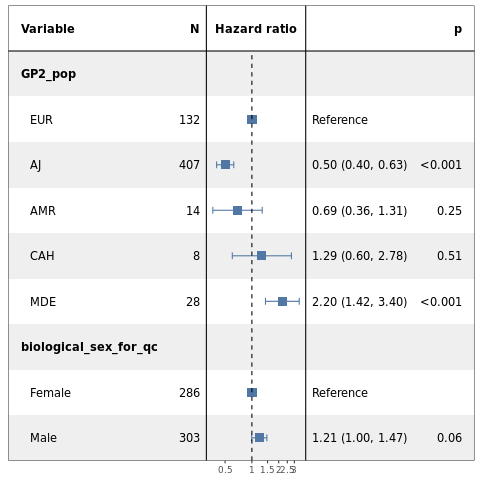

In [ ]:
%%R
# Change working directory
setwd('/home/jupyter/LRRK2_data_vis/')

# Import necessary libraries
library(forestmodel)
library("survival")

# Exclude population CAH, because N=4 are left after filtering
data_work_CPHM_sub <- subset(data_work_CPHM, !is.na(Status_CPHM) & 
                             !is.na(Age_CPHM) & LRRK2_iPD_status == "LRRK2-PD" )
# Subset for ancestries of interest
data_work_CPHM_sub <- subset(data_work_CPHM_sub, GP2_pop == "EUR" | GP2_pop == "AJ" |
                             GP2_pop == "AMR" | GP2_pop == "MDE" | GP2_pop == "CAH")
# Convert to dataframe
data_work_CPHM_sub <- as.data.frame(data_work_CPHM_sub)

# Get summary stats for data_work_CPHM_sub dataframe
summary(data_work_CPHM_sub)


# Convert to factors
data_work_CPHM_sub$GP2_pop <- as.factor(data_work_CPHM_sub$GP2_pop)
data_work_CPHM_sub$Status_CPHM <- as.factor(data_work_CPHM_sub$Status_CPHM)
data_work_CPHM_sub$biological_sex_for_qc <- as.factor(data_work_CPHM_sub$biological_sex_for_qc)

# Drop factor levels after subsetting
data_work_CPHM_sub$GP2_pop = droplevels(data_work_CPHM_sub$GP2_pop) 
data_work_CPHM_sub$Status_CPHM = droplevels(data_work_CPHM_sub$Status_CPHM) 
data_work_CPHM_sub$biological_sex_for_qc = droplevels(data_work_CPHM_sub$biological_sex_for_qc) 

# Use EUR as reference
data_work_CPHM_sub$GP2_pop <- relevel(data_work_CPHM_sub$GP2_pop, ref = "EUR")
# Transform Status_CPHM to numeric
data_work_CPHM_sub$Status_CPHM <- as.numeric(data_work_CPHM_sub$Status_CPHM)

# Run Cox analyses for GP2 populations with Age_CPHM and Status_CPHM
res_oneletter.cox <- coxph(Surv(Age_CPHM, Status_CPHM) ~ GP2_pop + 
                           biological_sex_for_qc, data = data_work_CPHM_sub)

# Get summary stats for res_oneletter.cox
summary(res_oneletter.cox)

# Create a plot for the Cox analysis results
d <- forest_model(res_oneletter.cox,
             theme = theme_forest(),
             covariates = c("GP2_pop", "biological_sex_for_qc"),
             exponentiate = TRUE,
             factor_separate_line = TRUE,
             merge_models = TRUE,
             format_options = forest_model_format_options(colour = "#5177A4",
                                                          shape = 15,
                                                          text_size = 4,
                                                          point_size = 4,
                                                          banded = TRUE))
# Show plot
d

#### Cox analyses for GP2 populations and corr. survival curves

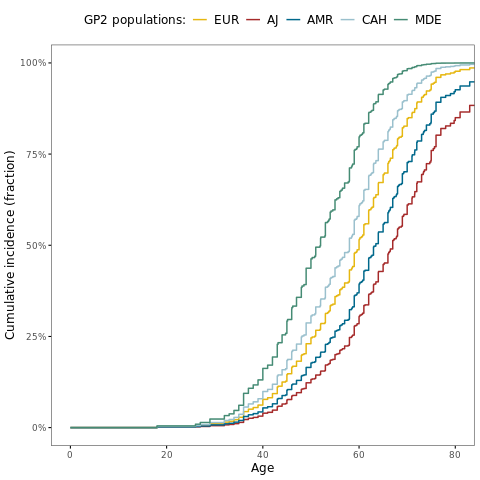

In [ ]:
%%R
# Change working directory
setwd('/home/jupyter/LRRK2_data_vis/')

# Create a pop_df dataframe with GP2_pop ancestries of interest and biological_sex_for_qc
pop_df <- with(data_work_CPHM_sub,
                     data.frame(GP2_pop = c("EUR", "AJ", "AMR", "CAH", "MDE"),
                                biological_sex_for_qc = c("Female", "Female", "Female", "Female", "Female")
                     )
)

# Show pop_df
pop_df

# Use the fitted res_oneletter.cox model 
fit_LRRK2 <- survfit(res_oneletter.cox, newdata = pop_df)

# Create sutvival plot for pop_df for "EUR", "AJ", "AMR", "CAH", "MDE" ancestries
ggsurvplot(fit_LRRK2,data=pop_df, conf.int = FALSE , pval = FALSE, surv.scale = "percent",
           fun = "event", legend.labs=c("EUR", "AJ", "AMR", "CAH", "MDE"), font.x = 12, 
           font.legend = 12, font.y = 12, size=0.7, censor=FALSE, 
           palette = c('#e6b710','#A52A2A', '#00688B','#9AC0CD', '#458B74'),
           ggtheme = theme_bw() + theme(text=element_text(family="Calibri"), 
           plot.caption = element_text(size = 12), panel.grid.major = element_blank(), 
           panel.grid.minor = element_blank()) , 
           xlab = "Age", ylab = c("Cumulative incidence (fraction)"), 
           legend.title="GP2 populations:" )

In addition: Warning message:
In recalculate_width_panels(panel_positions, mapped_text = mapped_text,  :
  Unable to resize forest panel to be smaller than its heading; consider a smaller text size


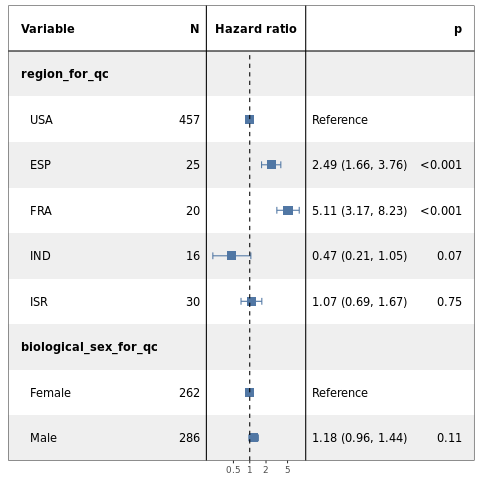

In [ ]:
%%R
# Change working directory
setwd('/home/jupyter/LRRK2_data_vis/')

# Create a new subset for countries of interest
data_country <- data_work_CPHM_sub
data_country_sub <- subset(data_country, region_for_qc== 'USA'| region_for_qc == 'ESP'|
                                 region_for_qc== 'FRA'| region_for_qc == 'IND'| region_for_qc == 'ISR')

# Convert to factors
data_country_sub$region_for_qc <- as.factor(data_country_sub$region_for_qc)
data_country_sub$Status_CPHM <- as.factor(data_country_sub$Status_CPHM)
data_country_sub$biological_sex_for_qc <- as.factor(data_country_sub$biological_sex_for_qc)

# Drop factor levels after subsetting
data_country_sub$region_for_qc = droplevels(data_country_sub$region_for_qc) 
data_country_sub$Status_CPHM = droplevels(data_country_sub$Status_CPHM) 
data_country_sub$biological_sex_for_qc = droplevels(data_country_sub$biological_sex_for_qc) 

# Use USA as reference
data_country_sub$region_for_qc <- relevel(data_country_sub$region_for_qc, ref = "USA")
# Transform Status_CPHM to numeric
data_country_sub$Status_CPHM <- as.numeric(data_country_sub$Status_CPHM)

# Run Cox analyses for GP2 populations with Age_CPHM and Status_CPHM
res_oneletter.cox <- coxph(Surv(Age_CPHM, Status_CPHM) ~ region_for_qc + 
                           biological_sex_for_qc, data = data_country_sub)

# Get summary stats for res_oneletter.cox
summary(res_oneletter.cox)

# Create a plot for the Cox analysis results
d <- forest_model(res_oneletter.cox,
             theme = theme_forest(),
             covariates = c("region_for_qc", "biological_sex_for_qc"),
             exponentiate = TRUE,
             factor_separate_line = TRUE,
             merge_models = TRUE,
             format_options = forest_model_format_options(colour = "#5177A4",
                                                          shape = 15,
                                                          text_size = 4,
                                                          point_size = 4,
                                                          banded = TRUE))
# Show plot
d

#### Cox analyses for GP2 countries and corr. survival curves

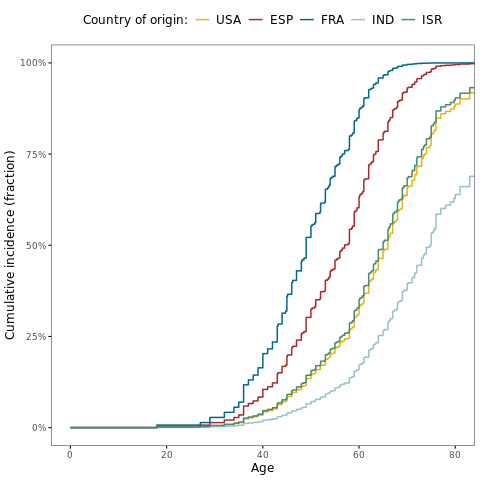

In [ ]:
%%R
# Change working directory
setwd('/home/jupyter/LRRK2_data_vis/')

# Import necessary libraries
library("survminer")

# Create a pop_df dataframe with countries of interest and biological_sex_for_qc
pop_df <- with(data_country_sub,
                     data.frame(region_for_qc = c("USA", "ESP", "FRA", "IND", "ISR"),
                                biological_sex_for_qc = c("Female", "Female", "Female", "Female", "Female")
                     )
)

# Show pop_df
pop_df

# Use the fitted res_oneletter.cox model 
fit_LRRK2 <- survfit(res_oneletter.cox, newdata = pop_df)

# Create sutvival plot for pop_df for "USA", "ESP", "FRA", "IND", "ISR" countries
ggsurvplot(fit_LRRK2,data=pop_df, conf.int = FALSE , pval = FALSE, surv.scale = "percent",
           fun = "event", legend.labs=c("USA", "ESP", "FRA", "IND", "ISR"), font.x = 12, 
           font.legend = 12, font.y = 12, size=0.7, censor=FALSE, 
           palette = c('#e6b710','#A52A2A', '#00688B','#9AC0CD', '#458B74'),
           ggtheme = theme_bw() + theme(text=element_text(family="Calibri"), 
           plot.caption = element_text(size = 12), panel.grid.major = element_blank(), 
           panel.grid.minor = element_blank()) , 
           xlab = "Age", ylab = c("Cumulative incidence (fraction)"), 
           legend.title="Country of origin:" ) 

## Saving

Save the final files to your workspace bucket, since we are conducting this analysis on Terra.